In [18]:
!pip install numpy pandas tensorflow scikit-learn matplotlib

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
dataset = pd.read_csv('Exp_Mn_Mw_Value.txt', sep='\t')
X = dataset.iloc[:, 1:5].values   # columns 1–4: Factor A–D
y = dataset.iloc[:, 5:7].values   # columns 5–6: Responses Mn, Mw
dataset.head()

,Run,Factor A,Factor B,Factor C,Factor D,Response 1 (Experimental),Response 2 (Experimental)
0,1,110,7,50,10,1127.19,1321.65
1,2,85,13,50,10,1024.97,1339.35
2,3,101,1,500,60,1950.00,2878.90
3,4,101,1,500,60,2223.17,2989.00
4,5,50,10,50,10,1845.60,2690.50


In [38]:
#normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y)

In [45]:
# Split data into 60% train, 20% validation, 20% test
# First split: 60% train, 40% temp (which will become 20% val + 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y_normalized, test_size=0.4, random_state=42
)

# Second split: split the 40% temp into 20% validation and 20% test
# Since temp is 40% of total, splitting it 50/50 gives us 20%/20% of total
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)
# Print the sizes to verify
print(f"\nDataset split:")
print(f"Total samples: {len(X_normalized)}")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_normalized)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_normalized)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_normalized)*100:.1f}%)")

print(f"\nFeature shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

print(f"\nTarget shapes:")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"y_test: {y_test.shape}")


Dataset split:
Total samples: 25
Training set: 15 samples (60.0%)
Validation set: 5 samples (20.0%)
Test set: 5 samples (20.0%)

Feature shapes:
X_train: (15, 4)
X_val: (5, 4)
X_test: (5, 4)

Target shapes:
y_train: (15, 2)
y_val: (5, 2)
y_test: (5, 2)


In [47]:
# Neural Network Analysis - Beginner Friendly Version
# We'll test different activation functions and neuron counts


print("NEURAL NETWORK ANALYSIS")


def create_neural_network(neurons, activation_function):
    """
    Create a simple neural network
    - neurons: number of neurons in hidden layer
    - activation_function: 'relu', 'tanh', 'sigmoid'
    """
    model = Sequential()
    
    # Input layer - we have 4 features (Factor A, B, C, D)
    model.add(Dense(neurons, input_shape=(4,), activation=activation_function))
    
    # Output layer - we predict 2 values (Mn and Mw)
    model.add(Dense(2, activation='linear'))  # linear for regression
    
    # Compile the model (set up for training)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Test different settings
neuron_counts = [8, 13, 20]  # different network sizes
activation_functions = ['relu', 'tanh', 'sigmoid', 'linear']  # different activation functions
# Note: 'linear' is the same as 'purelin' in TensorFlow/Keras

# Store all results
all_results = {}

print("Testing different neural network configurations...")


# Test each combination
for activation in activation_functions:
    print(f"Testing activation function: {activation.upper()}")

    for neurons in neuron_counts:
        print(f"  → Testing {neurons} neurons with {activation} activation...")
        
        # Set up 5-fold cross validation
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        r2_scores = []  # store R² score for each fold
        
        fold_number = 1
        
        # Do cross validation
        for train_idx, val_idx in kfold.split(X_train):
            # Split training data into train and validation for this fold
            X_train_fold = X_train[train_idx]
            X_val_fold = X_train[val_idx]
            y_train_fold = y_train[train_idx]
            y_val_fold = y_train[val_idx]
            
            # Create a new model for this fold
            model = create_neural_network(neurons, activation)
            
            # Set up early stopping to prevent overfitting
            early_stopping = EarlyStopping(
                monitor='val_loss',     # watch validation loss
                patience=20,            # stop if no improvement for 20 epochs
                restore_best_weights=True  # use best weights, not last
            )
            
            # Train the model
            model.fit(
                X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=200,             # maximum training rounds
                batch_size=8,           # process 8 samples at a time
                verbose=0,              # don't print training progress
                callbacks=[early_stopping]
            )
            
            # Make predictions on validation set
            y_pred_fold = model.predict(X_val_fold, verbose=0)
            
            # Calculate how good the predictions are (R² score)
            r2 = r2_score(y_val_fold, y_pred_fold)
            r2_scores.append(r2)
            
            print(f"     Fold {fold_number}: R² = {r2:.4f}")
            fold_number += 1
        
        # Calculate average performance across all folds
        avg_r2 = np.mean(r2_scores)
        std_r2 = np.std(r2_scores)
        
        # Store results
        config_name = f"{activation}_{neurons}neurons"
        all_results[config_name] = {
            'activation': activation,
            'neurons': neurons,
            'avg_r2': avg_r2,
            'std_r2': std_r2,
            'all_scores': r2_scores
        }
        
        print(f"     → Average R²: {avg_r2:.4f} ± {std_r2:.4f}")
        print()
    
    print()

# Find the best configuration

print("RESULTS SUMMARY")


print("All configurations tested:")
print()

# Sort results by average R² score (best first)
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['avg_r2'], reverse=True)

for i, (config_name, results) in enumerate(sorted_results):
    rank = i + 1
    activation = results['activation']
    neurons = results['neurons']
    avg_r2 = results['avg_r2']
    std_r2 = results['std_r2']
    
    print(f"{rank}. {activation.upper()} with {neurons} neurons: R² = {avg_r2:.4f} ± {std_r2:.4f}")

# Get the best configuration
best_config = sorted_results[0][1]
best_activation = best_config['activation']
best_neurons = best_config['neurons']
best_avg_r2 = best_config['avg_r2']

print()
print(" BEST CONFIGURATION:")
print(f"   Activation function: {best_activation.upper()}")
print(f"   Number of neurons: {best_neurons}")
print(f"   Average R²: {best_avg_r2:.4f}")

# Train final model with best configuration

print("TRAINING FINAL MODEL")


print(f"Training final model with {best_activation} activation and {best_neurons} neurons...")

# Create and train the final model
final_model = create_neural_network(best_neurons, best_activation)

# Use validation set for early stopping in final training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,  # a bit more patience for final model
    restore_best_weights=True
)

# Train on full training set, validate on validation set
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=8,
    verbose=1,  # show progress for final training
    callbacks=[early_stopping]
)

# Test the final model
print("\nTesting final model on test set...")
y_pred_test = final_model.predict(X_test, verbose=0)
final_r2 = r2_score(y_test, y_pred_test)

print(f"\n FINAL RESULTS:")
print(f"   Test set R²: {final_r2:.4f}")

# Calculate individual R² for each output (Mn and Mw)
r2_mn = r2_score(y_test[:, 0], y_pred_test[:, 0])  # First output (Mn)
r2_mw = r2_score(y_test[:, 1], y_pred_test[:, 1])  # Second output (Mw)

print(f"   R² for Mn: {r2_mn:.4f}")
print(f"   R² for Mw: {r2_mw:.4f}")


# DETAILED COMPARISON SECTION

print("DETAILED ACTIVATION FUNCTION COMPARISON")


# Group results by activation function
activation_comparison = {}
for config_name, results in all_results.items():
    activation = results['activation']
    if activation not in activation_comparison:
        activation_comparison[activation] = []
    activation_comparison[activation].append(results)

print("Comparing each activation function across all neuron counts:\n")

for activation in ['relu', 'tanh', 'sigmoid', 'linear']:
    if activation in activation_comparison:
        print(f" {activation.upper()} ACTIVATION FUNCTION:")
        print("-" * 40)
        
        configs = activation_comparison[activation]
        # Sort by neurons for clear display
        configs_sorted = sorted(configs, key=lambda x: x['neurons'])
        
        best_for_this_activation = max(configs, key=lambda x: x['avg_r2'])
        
        for config in configs_sorted:
            neurons = config['neurons']
            avg_r2 = config['avg_r2']
            std_r2 = config['std_r2']

NEURAL NETWORK ANALYSIS
Testing different neural network configurations...
This may take a few minutes...

Testing activation function: RELU
  → Testing 8 neurons with relu activation...
     Fold 1: R² = -10.8879


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = 0.4045


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -0.1155


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = 0.5971


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.6465
     → Average R²: -1.8711 ± 4.5165

  → Testing 13 neurons with relu activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -3.0251


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = 0.0788


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -9.2042


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = -0.5458


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.6321
     → Average R²: -2.4128 ± 3.6184

  → Testing 20 neurons with relu activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -3.0625


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = 0.7424


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -0.3842


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = -0.4957


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.8736
     → Average R²: -0.4653 ± 1.4145


Testing activation function: TANH
  → Testing 8 neurons with tanh activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -0.4315


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = 0.2709


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -8.7957


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = 0.1261


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.8000
     → Average R²: -1.6060 ± 3.6162

  → Testing 13 neurons with tanh activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -2.5570


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = 0.5861


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -0.6934


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = -0.1561


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.8201
     → Average R²: -0.4001 ± 1.2049

  → Testing 20 neurons with tanh activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -13.2527


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = 0.7384


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -4.4397


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = 0.2782


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.7892
     → Average R²: -3.1773 ± 5.4058


Testing activation function: SIGMOID
  → Testing 8 neurons with sigmoid activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -1.3385


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = 0.1011


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = 0.4760


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = -3.1889


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = -0.4035
     → Average R²: -0.8708 ± 1.3091

  → Testing 13 neurons with sigmoid activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -1.4827


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = -0.3209


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -0.3747


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = -5.4208


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.0258
     → Average R²: -1.5147 ± 2.0177

  → Testing 20 neurons with sigmoid activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -5.7508


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = -0.0800


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -0.7322


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = -1.1197


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.2893
     → Average R²: -1.4787 ± 2.1917


Testing activation function: LINEAR
  → Testing 8 neurons with linear activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -22.3846


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = 0.3377


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -6.0016


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = -1.6776


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.7967
     → Average R²: -5.7859 ± 8.6403

  → Testing 13 neurons with linear activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -6.2075


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = 0.2540


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -0.0212


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = 0.0042


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.6997
     → Average R²: -1.0542 ± 2.5897

  → Testing 20 neurons with linear activation...


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 1: R² = -8.2827


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 2: R² = 0.1526


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 3: R² = -0.0147


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 4: R² = 0.2191


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     Fold 5: R² = 0.7620
     → Average R²: -1.4327 ± 3.4349


RESULTS SUMMARY
All configurations tested:

1. TANH with 13 neurons: R² = -0.4001 ± 1.2049
2. RELU with 20 neurons: R² = -0.4653 ± 1.4145
3. SIGMOID with 8 neurons: R² = -0.8708 ± 1.3091
4. LINEAR with 13 neurons: R² = -1.0542 ± 2.5897
5. LINEAR with 20 neurons: R² = -1.4327 ± 3.4349
6. SIGMOID with 20 neurons: R² = -1.4787 ± 2.1917
7. SIGMOID with 13 neurons: R² = -1.5147 ± 2.0177
8. TANH with 8 neurons: R² = -1.6060 ± 3.6162
9. RELU with 8 neurons: R² = -1.8711 ± 4.5165
10. RELU with 13 neurons: R² = -2.4128 ± 3.6184
11. TANH with 20 neurons: R² = -3.1773 ± 5.4058
12. LINEAR with 8 neurons: R² = -5.7859 ± 8.6403

 BEST CONFIGURATION:
   Activation function: TANH
   Number of neurons: 13
   Average R²: -0.4001
TRAINING FINAL MODEL
Training final model with tanh activation and 13 neurons...
Epoch 1/300


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.9180 - mae: 0.8118 - val_loss: 0.8531 - val_mae: 0.6683
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.8863 - mae: 0.7983 - val_loss: 0.8280 - val_mae: 0.6571
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.8547 - mae: 0.7825 - val_loss: 0.8073 - val_mae: 0.6480
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8255 - mae: 0.7685 - val_loss: 0.7854 - val_mae: 0.6384
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.7950 - mae: 0.7533 - val_loss: 0.7663 - val_mae: 0.6297
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.7738 - mae: 0.7412 - val_loss: 0.7489 - val_mae: 0.6214
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.7486 - mae: 0.7275 - val_loss: 0.7314 - val_mae: 0.6129
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.7213 - mae: 0.7128 - val_loss: 0.7139 - val_mae: 0.6043
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6986 - mae: 0.7007 - va

Preparing data for visualization...


Text(0, 0.5, 'R² Score')

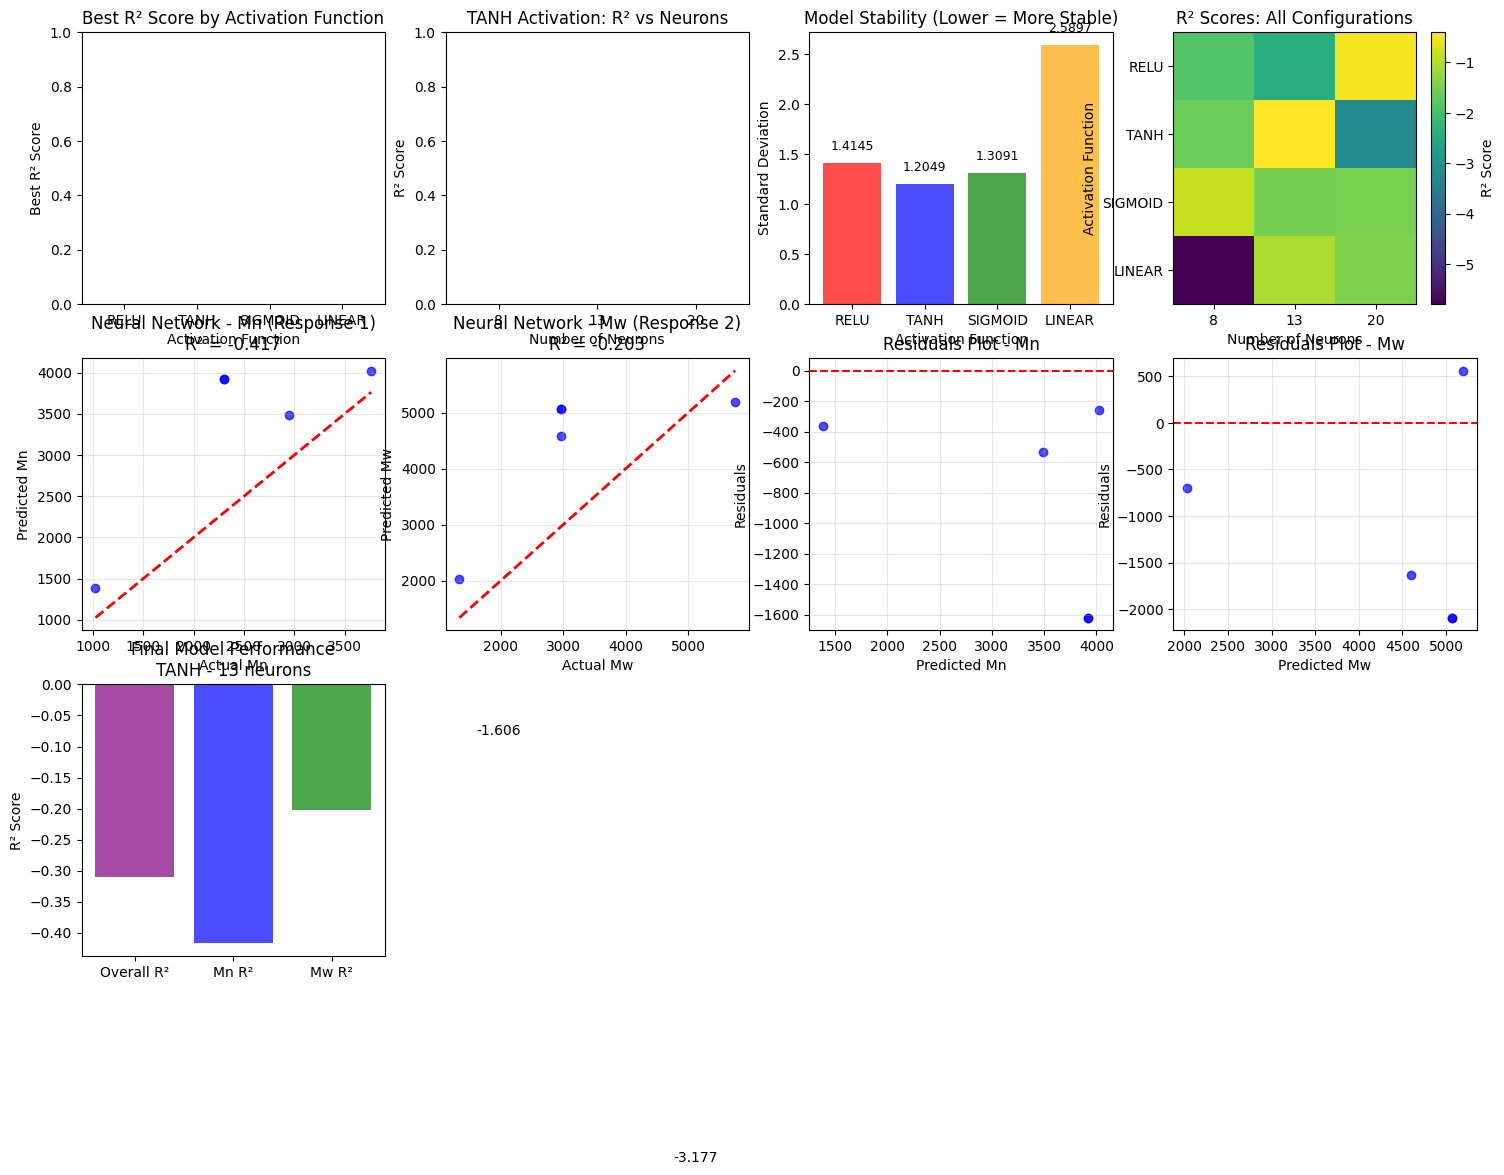

In [50]:
# First, we need to convert predictions back to original scale for plotting
# (since we normalized the data earlier)

print("Preparing data for visualization...")

# Convert test predictions back to original scale
y_pred_nn_original = scaler_y.inverse_transform(y_pred_test)
y_test_original = scaler_y.inverse_transform(y_test)

# Calculate R² for individual responses (Mn and Mw)
nn_r2_resp1 = r2_score(y_test_original[:, 0], y_pred_nn_original[:, 0])  # Response 1 (Mn)
nn_r2_resp2 = r2_score(y_test_original[:, 1], y_pred_nn_original[:, 1])  # Response 2 (Mw)

# Get all R² values for statistics (fix for the error)
all_r2_values = [results['avg_r2'] for results in all_results.values()]

# Create comprehensive plots
plt.figure(figsize=(18, 12))

# Plot 1: Activation Function Comparison
plt.subplot(3, 4, 1)
activation_names = []
best_r2_scores = []
best_neurons_list = []

for activation in ['relu', 'tanh', 'sigmoid', 'linear']:
    if activation in activation_comparison:
        best_config = max(activation_comparison[activation], key=lambda x: x['avg_r2'])
        activation_names.append(activation.upper())
        best_r2_scores.append(best_config['avg_r2'])
        best_neurons_list.append(best_config['neurons'])

colors = ['red', 'blue', 'green', 'orange']
bars = plt.bar(activation_names, best_r2_scores, color=colors, alpha=0.7)
plt.title('Best R² Score by Activation Function')
plt.xlabel('Activation Function')
plt.ylabel('Best R² Score')
plt.ylim(0, 1)

# Add value labels on bars
for i, (v, neurons) in enumerate(zip(best_r2_scores, best_neurons_list)):
    plt.text(i, v + 0.02, f'{v:.3f}\n({neurons} neurons)', ha='center', fontsize=9)

# Plot 2: Neuron Count Comparison for Best Activation
plt.subplot(3, 4, 2)
best_activation_configs = activation_comparison[best_activation]
neuron_counts_sorted = sorted([config['neurons'] for config in best_activation_configs])
r2_for_neurons = []

for neurons in neuron_counts_sorted:
    config = next(c for c in best_activation_configs if c['neurons'] == neurons)
    r2_for_neurons.append(config['avg_r2'])

plt.bar([str(n) for n in neuron_counts_sorted], r2_for_neurons, 
        color='blue', alpha=0.7, capsize=5)
plt.title(f'{best_activation.upper()} Activation: R² vs Neurons')
plt.xlabel('Number of Neurons')
plt.ylabel('R² Score')
plt.ylim(0, 1)

for i, v in enumerate(r2_for_neurons):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center')

# Plot 3: Cross-validation stability comparison
plt.subplot(3, 4, 3)
std_devs = [results['std_r2'] for results in [max(activation_comparison[act], key=lambda x: x['avg_r2']) 
                                            for act in ['relu', 'tanh', 'sigmoid', 'linear'] 
                                            if act in activation_comparison]]
plt.bar(activation_names, std_devs, color=colors, alpha=0.7)
plt.title('Model Stability (Lower = More Stable)')
plt.xlabel('Activation Function')
plt.ylabel('Standard Deviation')

for i, v in enumerate(std_devs):
    plt.text(i, v + max(std_devs)*0.05, f'{v:.4f}', ha='center', fontsize=9)

# Plot 4: All configurations heatmap-style
plt.subplot(3, 4, 4)
# Create matrix for heatmap
activations = ['relu', 'tanh', 'sigmoid', 'linear']
neurons = [8, 13, 20]
r2_matrix = np.zeros((len(activations), len(neurons)))

for i, activation in enumerate(activations):
    if activation in activation_comparison:
        for config in activation_comparison[activation]:
            j = neurons.index(config['neurons'])
            r2_matrix[i, j] = config['avg_r2']

im = plt.imshow(r2_matrix, cmap='viridis', aspect='auto')
plt.colorbar(im, label='R² Score')
plt.title('R² Scores: All Configurations')
plt.xlabel('Number of Neurons')
plt.ylabel('Activation Function')
plt.xticks(range(len(neurons)), neurons)
plt.yticks(range(len(activations)), [a.upper() for a in activations])

# Add text annotations
for i in range(len(activations)):
    for j in range(len(neurons)):
        if r2_matrix[i, j] > 0:
            plt.text(j, i, f'{r2_matrix[i,j]:.3f}', ha='center', va='center', 
                    color='white' if r2_matrix[i,j] < 0.5 else 'black')

# Plot 5: Neural Network Response 1 (Mn) - Actual vs Predicted
plt.subplot(3, 4, 5)
plt.scatter(y_test_original[:, 0], y_pred_nn_original[:, 0], alpha=0.7, color='blue')
plt.plot([y_test_original[:, 0].min(), y_test_original[:, 0].max()], 
         [y_test_original[:, 0].min(), y_test_original[:, 0].max()], 'r--', lw=2)
plt.xlabel('Actual Mn')
plt.ylabel('Predicted Mn')
plt.title(f'Neural Network - Mn (Response 1)\nR² = {nn_r2_resp1:.3f}')
plt.grid(True, alpha=0.3)

# Plot 6: Neural Network Response 2 (Mw) - Actual vs Predicted
plt.subplot(3, 4, 6)
plt.scatter(y_test_original[:, 1], y_pred_nn_original[:, 1], alpha=0.7, color='blue')
plt.plot([y_test_original[:, 1].min(), y_test_original[:, 1].max()], 
         [y_test_original[:, 1].min(), y_test_original[:, 1].max()], 'r--', lw=2)
plt.xlabel('Actual Mw')
plt.ylabel('Predicted Mw')
plt.title(f'Neural Network - Mw (Response 2)\nR² = {nn_r2_resp2:.3f}')
plt.grid(True, alpha=0.3)

# Plot 7: Residuals plot for Response 1 (Mn)
plt.subplot(3, 4, 7)
residuals_1 = y_test_original[:, 0] - y_pred_nn_original[:, 0]
plt.scatter(y_pred_nn_original[:, 0], residuals_1, alpha=0.7, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Mn')
plt.ylabel('Residuals')
plt.title('Residuals Plot - Mn')
plt.grid(True, alpha=0.3)

# Plot 8: Residuals plot for Response 2 (Mw)
plt.subplot(3, 4, 8)
residuals_2 = y_test_original[:, 1] - y_pred_nn_original[:, 1]
plt.scatter(y_pred_nn_original[:, 1], residuals_2, alpha=0.7, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Mw')
plt.ylabel('Residuals')
plt.title('Residuals Plot - Mw')
plt.grid(True, alpha=0.3)

# Plot 9: Best model summary
plt.subplot(3, 4, 9)
metrics = ['Overall R²', 'Mn R²', 'Mw R²']
values = [final_r2, nn_r2_resp1, nn_r2_resp2]
bars = plt.bar(metrics, values, color=['purple', 'blue', 'green'], alpha=0.7)
plt.title(f'Final Model Performance\n{best_activation.upper()} - {best_neurons} neurons')
plt.ylabel('R² Score')